In [45]:
# Import required libraries
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
import re
from textblob import TextBlob

In [46]:
# nltk library needs to download some resources
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prais\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\prais\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prais\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [80]:
#import the dataset
df = pd.read_csv('AirbnbSample7.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5000 non-null   int64  
 1   name                      4986 non-null   object 
 2   host_identity_verified    4986 non-null   object 
 3   neighborhood              4996 non-null   object 
 4   country                   4976 non-null   object 
 5   instant_bookable          4996 non-null   object 
 6   cancellation_policy       4997 non-null   object 
 7   room_type                 5000 non-null   object 
 8   construction_year         4990 non-null   float64
 9   price                     4986 non-null   float64
 10  service_fee               4989 non-null   float64
 11  minimum_nights            4986 non-null   float64
 12  number_of_reviews         4990 non-null   float64
 13  last_review_time          4220 non-null   object 
 14  reviews_

In [48]:
# Columns to keep for analysis
columns_to_keep = ['id','price', 'room_type', 'neighborhood', 'cancellation_policy', 
    'construction_year', 'star_rating', 'number_of_reviews', 
    'available_days_in_future', 'host_identity_verified', 'host_listings_count','house_rules']

In [49]:
# Dropping columns that are not required for the analysis
dataset_for_analysis = df[columns_to_keep].copy()

# Display the first few rows of the cleaned dataset
dataset_for_analysis.head()

,id,price,room_type,neighborhood,cancellation_policy,construction_year,star_rating,number_of_reviews,available_days_in_future,host_identity_verified,host_listings_count,house_rules
0,75764,545.0,Private room,Manhattan,moderate,2013.0,5.0,1.0,0.0,unconfirmed,1.0,NaN
1,43017,847.0,Private room,Brooklyn,strict,2019.0,2.0,0.0,356.0,verified,1.0,"Unlike most other Airbnb listings, what we do ..."
2,28380,1124.0,Private room,Bronx,moderate,2009.0,5.0,11.0,338.0,verified,1.0,NaN
3,89235,306.0,Entire home/apt,Manhattan,moderate,2019.0,1.0,0.0,0.0,unconfirmed,1.0,NaN
4,79985,702.0,Entire home/apt,Manhattan,moderate,2003.0,3.0,2.0,251.0,unconfirmed,91.0,NaN


In [50]:
host_identity_verified_map = {"verified":1,"unconfirmed":0}

# Map original values to their numeric equivalents
if 'host_identity_verified' in dataset_for_analysis.columns:
   dataset_for_analysis['host_identity_verified'] = dataset_for_analysis['host_identity_verified'].map(host_identity_verified_map)
    
cancellation_policy_map = {'moderate':1, 'strict':2, 'flexible':3}

# Map original values to their numeric equivalents
if 'cancellation_policy' in dataset_for_analysis.columns:
   dataset_for_analysis['cancellation_policy'] = dataset_for_analysis['cancellation_policy'].map(cancellation_policy_map)

# Map original values to their numeric equivalents
if 'room_type' in dataset_for_analysis.columns:
   dataset_for_analysis['room_type'] = dataset_for_analysis['room_type'].map(room_type_map)

In [51]:
dataset_for_analysis.head(100)

,id,price,room_type,neighborhood,cancellation_policy,construction_year,star_rating,number_of_reviews,available_days_in_future,host_identity_verified,host_listings_count,house_rules
0,75764,545.0,1,Manhattan,1.0,2013.0,5.0,1.0,0.0,0.0,1.0,NaN
1,43017,847.0,1,Brooklyn,2.0,2019.0,2.0,0.0,356.0,1.0,1.0,"Unlike most other Airbnb listings, what we do ..."
2,28380,1124.0,1,Bronx,1.0,2009.0,5.0,11.0,338.0,1.0,1.0,NaN
3,89235,306.0,2,Manhattan,1.0,2019.0,1.0,0.0,0.0,0.0,1.0,NaN
4,79985,702.0,2,Manhattan,1.0,2003.0,3.0,2.0,251.0,0.0,91.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,88145,135.0,3,Queens,2.0,2016.0,5.0,18.0,365.0,1.0,6.0,NaN
96,63906,252.0,2,Brooklyn,1.0,2014.0,5.0,0.0,0.0,0.0,1.0,I feel very responsible and accountable for yo...
97,64929,1083.0,2,Brooklyn,3.0,2022.0,5.0,35.0,249.0,0.0,2.0,NaN
98,47622,962.0,1,Queens,2.0,2021.0,4.0,73.0,343.0,0.0,1.0,- Guests are expected to keep the house in goo...


In [52]:
print('Number of missing values:')
for col in dataset_for_analysis.columns:
    num_Missing_Value = sum(dataset_for_analysis[col].isna())
    print('{}:{}'.format(col,num_Missing_Value))

Number of missing values:
id:0
price:14
room_type:0
neighborhood:4
cancellation_policy:3
construction_year:10
star_rating:7
number_of_reviews:10
available_days_in_future:17
host_identity_verified:14
host_listings_count:15
house_rules:2476


In [53]:
# First, let's create binary indicators for missingness
dataset_for_analysis['number_of_reviews_missing_values'] = dataset_for_analysis['number_of_reviews'].isnull().astype(int)
dataset_for_analysis['available_days_in_future_missing_values'] = dataset_for_analysis['available_days_in_future'].isnull().astype(int)


Text(0.5, 1.0, 'Available days in the future by Price Missingness')

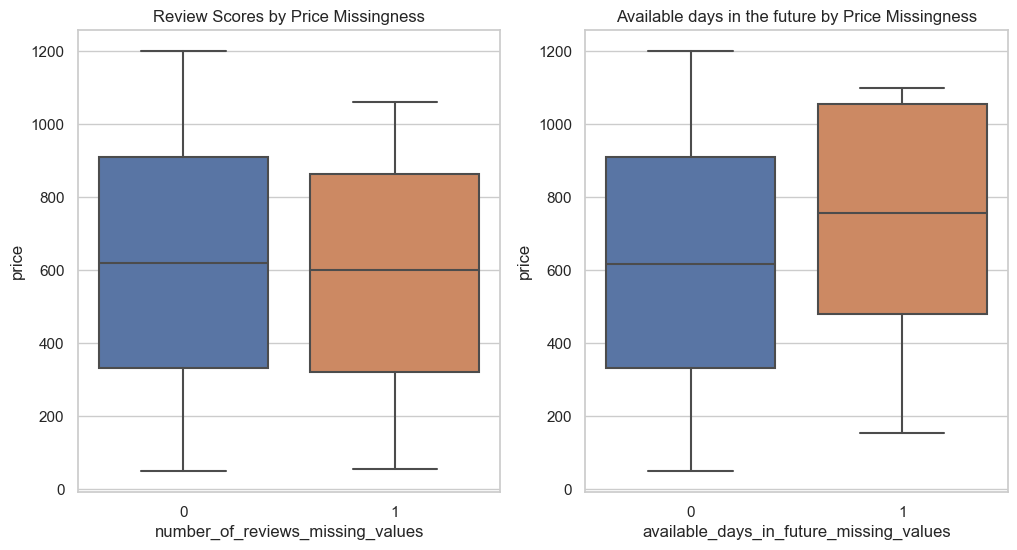

In [54]:
# Step 2: Visualization for missing patterns
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.boxplot(x='number_of_reviews_missing_values', y='price', data = dataset_for_analysis)
plt.title('Review Scores by Price Missingness')

plt.subplot(122)
sns.boxplot(x='available_days_in_future_missing_values', y='price', data=dataset_for_analysis)
plt.title('Available days in the future by Price Missingness')


In [55]:
# Step 1: Create missingness indicator columns for 'number_of_reviews' and 'available_days_in_future'
dataset_for_analysis['number_of_reviews_missing_values'] = dataset_for_analysis['number_of_reviews'].isnull().astype(int)
dataset_for_analysis['available_days_in_future_missing'] = dataset_for_analysis['available_days_in_future'].isnull().astype(int)

# Step 2: Define the function for T-tests
def perform_ttest(dataset_for_analysis, missing_col, test_col):
    missing = dataset_for_analysis[dataset_for_analysis[missing_col] == 1][test_col]
    not_missing = dataset_for_analysis[dataset_for_analysis[missing_col] == 0][test_col]
    t_stat, p_value = stats.ttest_ind(missing.dropna(), not_missing.dropna())
    return t_stat, p_value

# Step 3: Perform t-tests
number_of_reviews_ttest = perform_ttest(dataset_for_analysis, 'number_of_reviews_missing_values', 'price')
available_days_in_future_ttest = perform_ttest(dataset_for_analysis, 'available_days_in_future_missing', 'price')

# Step 4: Output results
print("\nT-test results:")
print(f"Number of Reviews missingness vs Prices: t-stat = {number_of_reviews_ttest[0]:.4f}, P-values = {number_of_reviews_ttest[1]:.4f}")
print(f"Available Days in Future missingness vs Prices: t-stat = {available_days_in_future_ttest[0]:.4f}, P-values = {available_days_in_future_ttest[1]:.4f}")



T-test results:
Number of Reviews missingness vs Prices: t-stat = -0.4075, P-values = 0.6837
Available Days in Future missingness vs Prices: t-stat = 1.1359, P-values = 0.2560


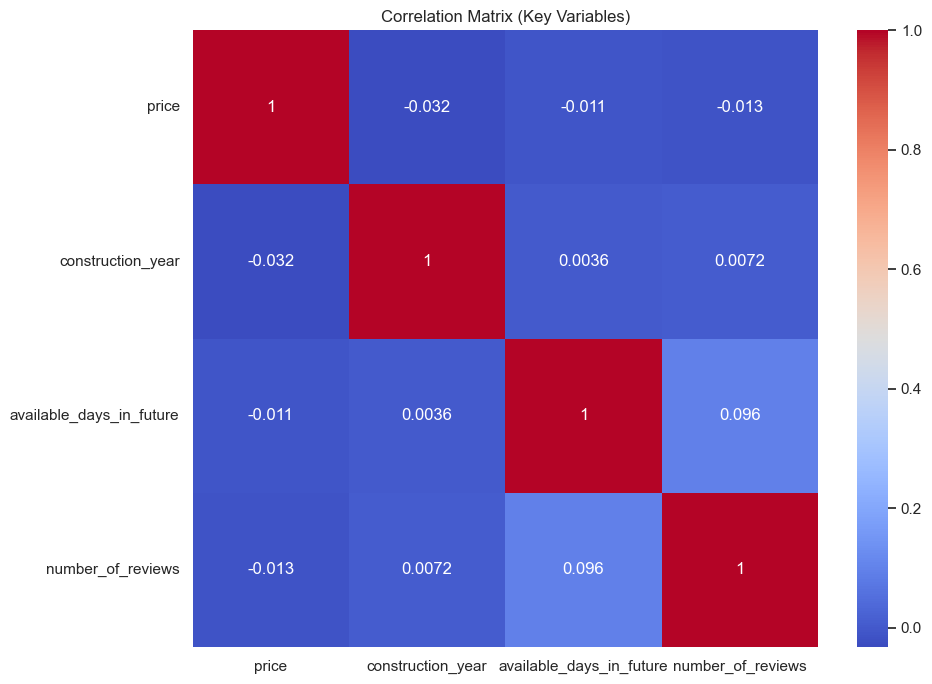

In [67]:
selected_columns = ['price', 'construction_year', 'available_days_in_future', 'number_of_reviews']
correlation_matrix = df[selected_columns].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Key Variables)')
plt.tight_layout()
plt.show()

In [62]:
# Investigate potential reasons for missingness in 'price' and 'construction_year'
# I'll explore relationships between missing 'price' and 'construction_year' with a few potentially related attributes.

# Convert the missing values into a new column indicating whether the value is missing (1 for missing, 0 for present)
dataset_for_analysis['price_missing'] = dataset_for_analysis['price'].isnull().astype(int)
dataset_for_analysis['construction_year_missing'] = dataset_for_analysis['construction_year'].isnull().astype(int)

# Attributes to explore relationships with: 'neighborhood', 'star_rating', 'number_of_reviews'
explore_columns = ['cancellation_policy', 'star_rating', 'number_of_reviews','available_days_in_future']

# Check for relationships between missing 'price' and 'construction_year' with selected attributes
price_missing_relationship = dataset_for_analysis.groupby('price_missing')[explore_columns].mean()
construction_year_missing_relationship = dataset_for_analysis.groupby('construction_year_missing')[explore_columns].mean()

price_missing_relationship, construction_year_missing_relationship

(               cancellation_policy  star_rating  number_of_reviews  \
 price_missing                                                        
 0                         1.979932     3.272946          27.487339   
 1                         2.142857     3.071429          16.714286   
 
                available_days_in_future  
 price_missing                            
 0                            143.255786  
 1                            220.500000  ,
                            cancellation_policy  star_rating  \
 construction_year_missing                                     
 0                                     1.979751     3.272125   
 1                                     2.333333     3.400000   
 
                            number_of_reviews  available_days_in_future  
 construction_year_missing                                               
 0                                  27.374498                143.303841  
 1                                  68.600000                

Missing Price: Listings with missing prices tend to have stricter cancellation policies, fewer reviews, and more availability in the future, which could indicate that these are either newer, less established listings or listings with incomplete information that might discourage potential renters.

Missing Construction Year: Listings with missing construction year data have stricter cancellation policies, higher numbers of reviews, and more future availability. This could point to older listings that lack updated data, or to properties that are more frequently reviewed but less booked for the near future.

In [22]:


# Select the relevant columns for KNN imputation (including the columns that might relate to price and construction year)
columns_for_imputation = ['price', 'construction_year', 'star_rating', 'number_of_reviews', 'neighborhood']

# Create a subset of the data for imputation
imputation_data = dataset_for_analysis[columns_for_imputation]

# Apply KNN imputation (using 5 nearest neighbors)
imputer = KNNImputer(n_neighbors = 5)
imputed_data = pd.DataFrame(imputer.fit_transform(imputation_data), columns = columns_for_imputation)

# Replace the original missing values with the imputed data
dataset_for_analysis['price'] = imputed_data['price']
dataset_for_analysis['construction_year'] = imputed_data['construction_year']

# Check if any missing values remain in the imputed columns
missing_after_imputation = dataset_for_analysis[['price', 'construction_year']].isnull().sum()

missing_after_imputation

price                0
construction_year    0
dtype: int64

Text(0.5, 1.0, 'price')

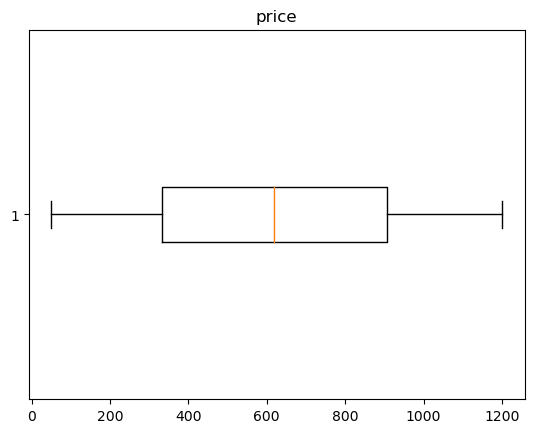

In [26]:
## Outliers 
### Detecting Outliers

#### Univariate outlier detection
plt.boxplot(dataset_for_analysis['price'].dropna(),vert=False)
plt.title("price")


There are no outliers in Prices

In [34]:
# Save the cleaned dataset to a new CSV file
dataset_for_analysis.to_csv("Cleaned_Airbnbdata2.csv", index=False)

DATA VISUALIZATION

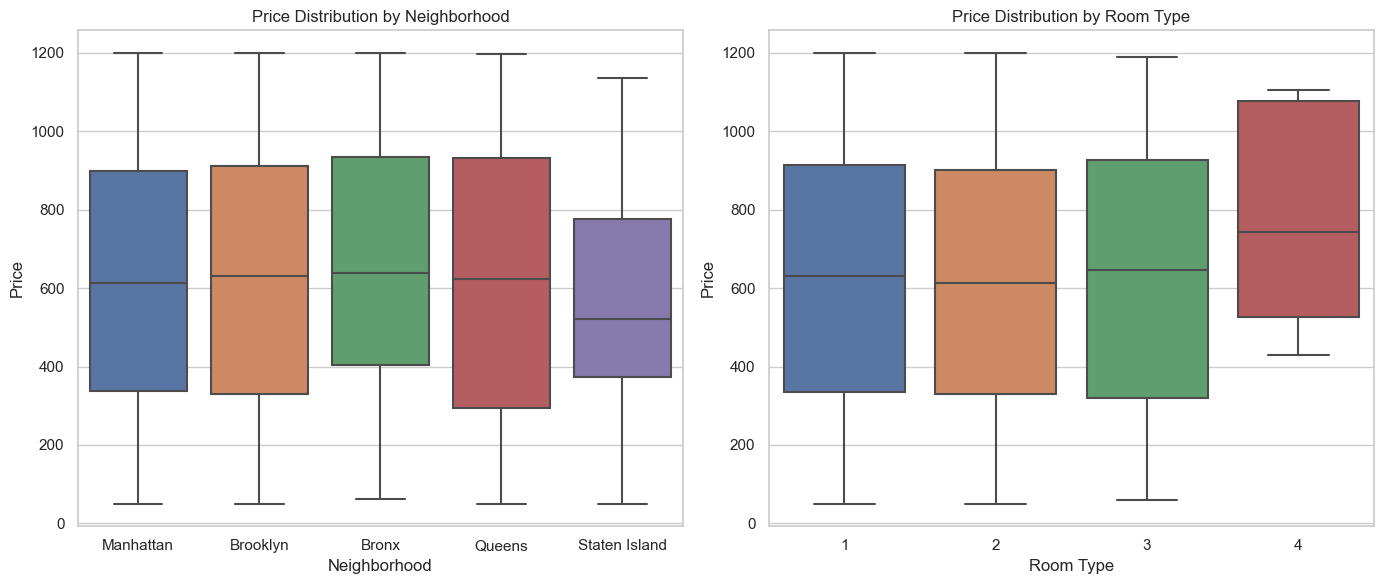

In [73]:

# Set plot aesthetics
sns.set(style="whitegrid")

# Visualize how price varies with neighborhood and room type
plt.figure(figsize=(14, 6))

# Plot 1: Price vs Neighborhood
plt.subplot(1, 2, 1)
sns.boxplot(x ='neighborhood', y ='price', data = dataset_for_analysis)
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')

# Plot 2: Price vs Room Type
plt.subplot(1, 2, 2)
sns.boxplot(x ='room_type', y ='price', data = dataset_for_analysis)
plt.title('Price Distribution by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


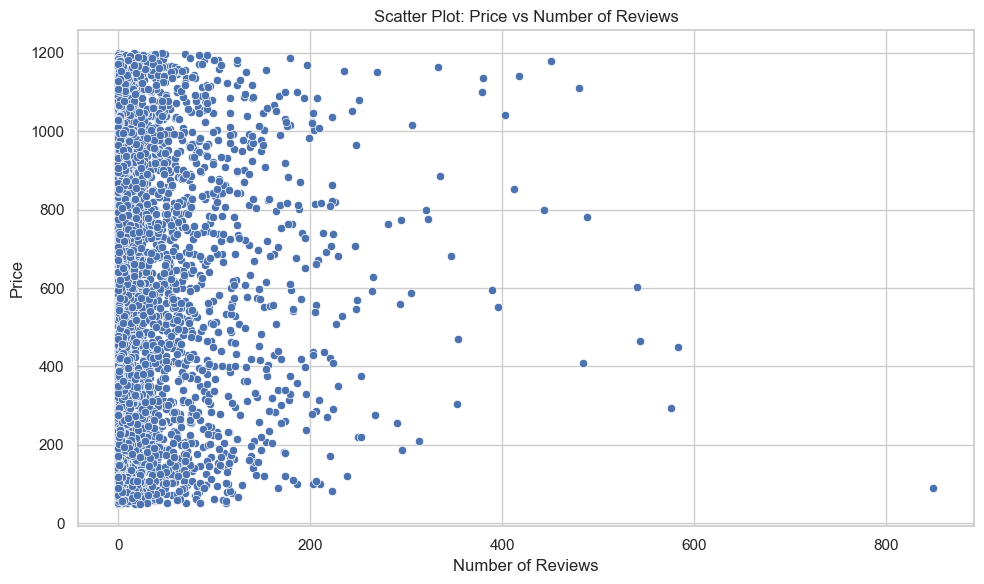

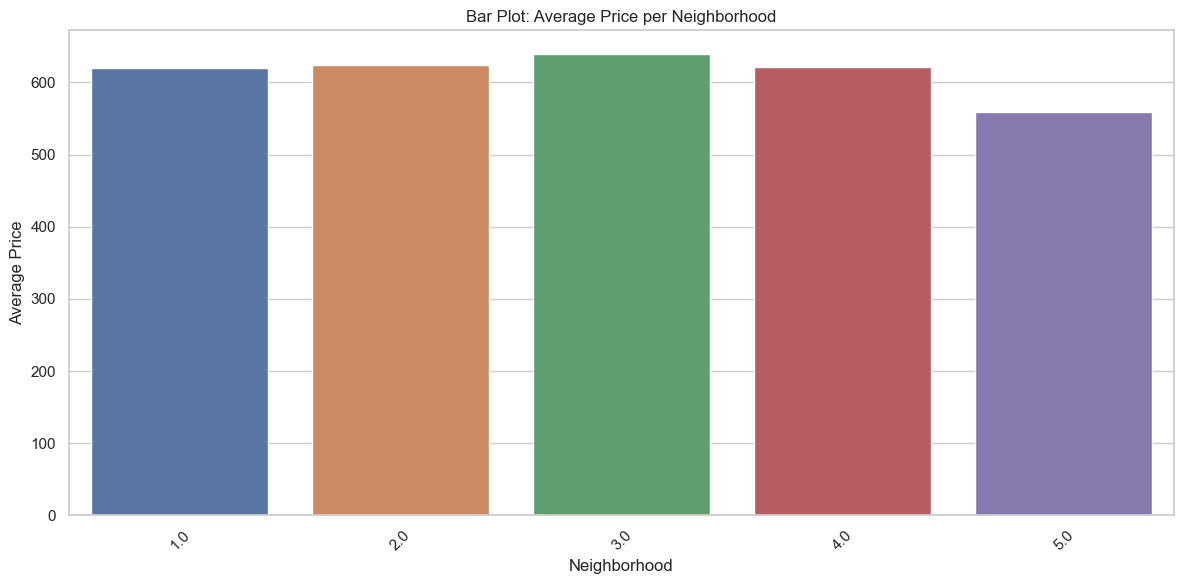

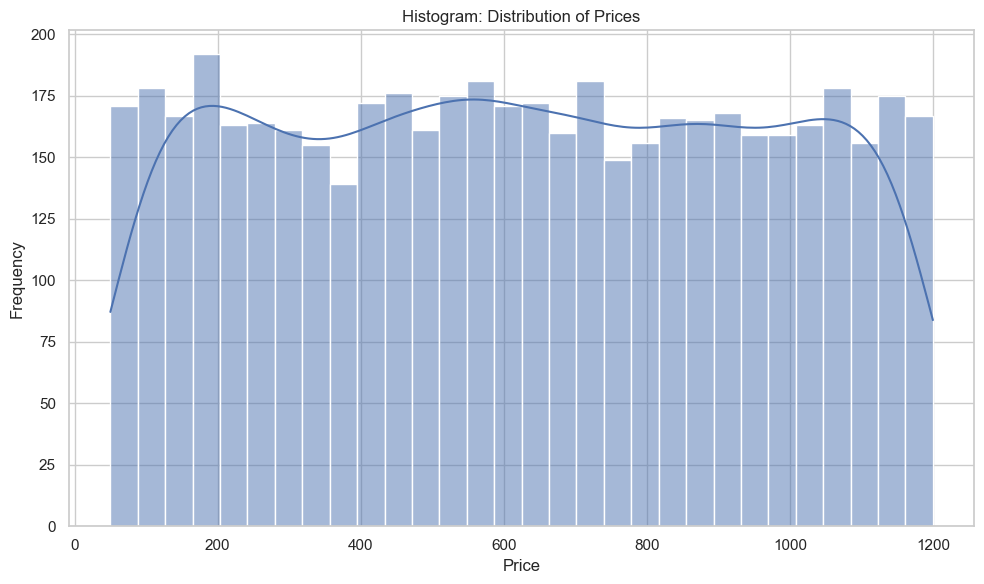

In [30]:
# 1. Scatter Plot: Price vs Number of Reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='number_of_reviews', y='price', data=dataset_for_analysis)
plt.title('Scatter Plot: Price vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# 2. Bar Plot: Average Price per Neighborhood
plt.figure(figsize=(12, 6))
avg_price_neighborhood = dataset_for_analysis.groupby('neighborhood')['price'].mean().sort_values()
sns.barplot(x=avg_price_neighborhood.index, y=avg_price_neighborhood.values)
plt.title('Bar Plot: Average Price per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Histogram: Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(dataset_for_analysis['price'], bins = 30, kde = True)
plt.title('Histogram: Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



Scatter Plot (Price vs Number of Reviews): This plot shows how price relates to the number of reviews. There doesn't seem to be a strong relationship, but it helps identify outliers (such as listings with very high prices or unusually many reviews).

Bar Plot (Average Price per Neighborhood): This plot compares the average price across different neighborhoods. Some neighborhoods clearly have higher average prices than others.

Histogram (Distribution of Prices): The histogram reveals how prices are distributed in the dataset. Most listings seem to cluster around a lower price range, with fewer expensive listings.

 TEXT MINING

In [77]:

# Select the 'house_rules' column and drop rows with NaN values
house_rules = dataset_for_analysis['house_rules'].dropna()

# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the preprocessing to the 'house_rules' data
house_rules_cleaned = house_rules.apply(preprocess_text)

# Display the first few cleaned entries
house_rules_cleaned.head()


1     unlike most other airbnb listings what we do h...
8                      no shoes in the apartment please
10                                   no smoking no pets
13    to keep house and house items in the same cond...
14    im a semi kosher vegetarian which means that i...
Name: house_rules, dtype: object

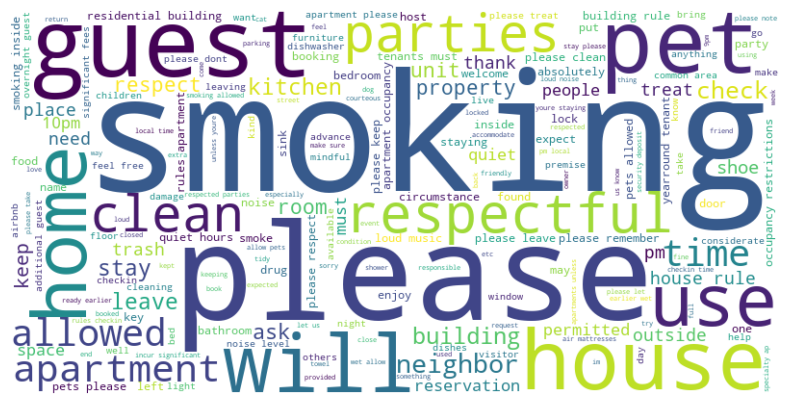

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the house rules into a single string
all_house_rules = ' '.join(house_rules_cleaned)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_house_rules)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


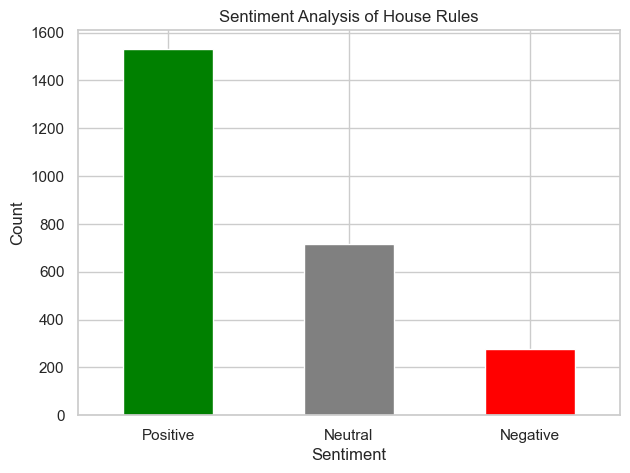

(None,
 house_rules
 Positive    1533
 Neutral      714
 Negative     277
 Name: count, dtype: int64)

In [75]:
from textblob import TextBlob

# Sentiment analysis function
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify as positive, neutral, or negative based on polarity
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis to the cleaned house rules
house_rules_sentiment = house_rules_cleaned.apply(get_sentiment)

# Count the occurrences of each sentiment category
sentiment_counts = house_rules_sentiment.value_counts()

# Plot the sentiment analysis results
plt.figure(figsize=(7, 5))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Analysis of House Rules')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show(), sentiment_counts


The majority of house rules have a positive tone, with a smaller portion being neutral or negative. The bar chart above visualizes this sentiment breakdown.

In [ ]:
INSIGHT FROM PLOTS AND ANALYSIS

In [ ]:
The majority of house rules have a positive tone, with a smaller portion being neutral or negative. The bar chart above visualizes this sentiment breakdown.

Missing Price: Listings with missing prices tend to have stricter cancellation policies, fewer reviews, and more availability in the future, which could indicate that these are either newer, less established listings or listings with incomplete information that might discourage potential renters.

Missing Construction Year: Listings with missing construction year data have stricter cancellation policies, higher numbers of reviews, and more future availability. This could point to older listings that lack updated data, or to properties that are more frequently reviewed but less booked for the near future.

Scatter Plot (Price vs Number of Reviews): This plot shows how price relates to the number of reviews. There doesn't seem to be a strong relationship, but it helps identify outliers (such as listings with very high prices or unusually many reviews).

Bar Plot (Average Price per Neighborhood): This plot compares the average price across different neighborhoods. Some neighborhoods clearly have higher average prices than others.

Histogram (Distribution of Prices): The histogram reveals how prices are distributed in the dataset. Most listings seem to cluster around a lower price range, with fewer expensive listings.